C:\Users\dell 4\AppData\Local\Temp\ipykernel_7092\1095080164.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
100%|██████████| 54/54 [6:55:15<00:00, 461.40s/it]    



✅ Accuracy: 0.86

Classification Report:
                                             precision    recall  f1-score   support

                           Apple Apple scab       0.86      0.81      0.84       175
                            Apple Black rot       0.86      0.87      0.87       175
                     Apple Cedar apple rust       0.90      0.92      0.91       175
                              Apple healthy       0.91      0.89      0.90       175
         Bacterial leaf blight in rice leaf       0.89      1.00      0.94        42
                        Blight in corn Leaf       0.71      0.75      0.73       175
                          Blueberry healthy       0.94      0.95      0.94       175
                    Brown spot in rice leaf       0.95      0.98      0.96        42
                       Cercospora leaf spot       0.93      0.94      0.93        66
     Cherry (including sour) Powdery mildew       0.97      0.95      0.96       175
            Cherry (in

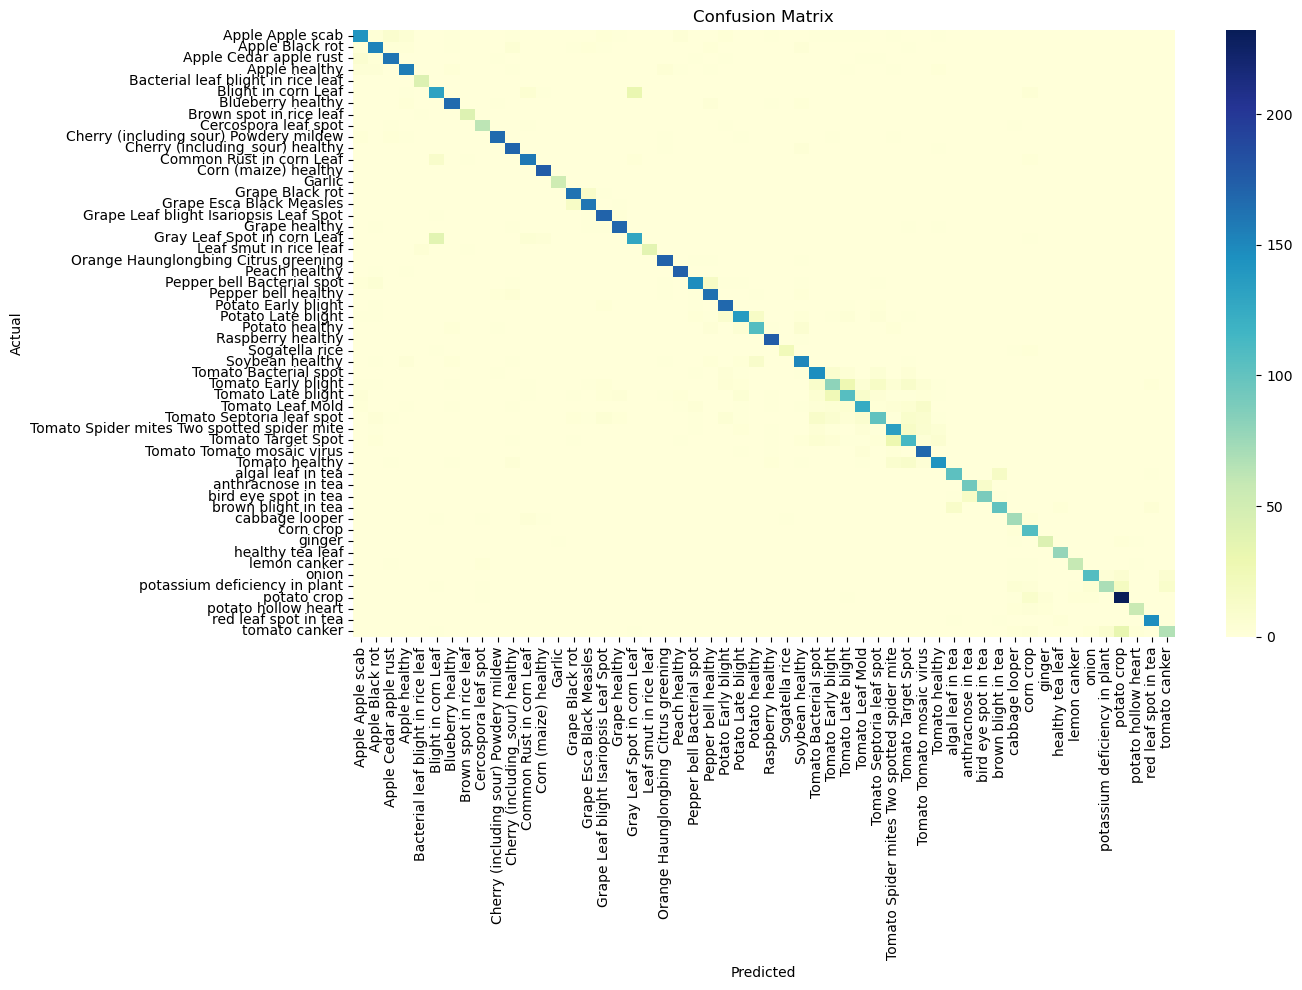

In [24]:
import os
import random
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
import joblib
from tqdm import tqdm

# Load MobileNetV2 for feature extraction
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Dataset directory
DATA_DIR = r"D:\\dataset\\Image Data base"
MAX_IMAGES_PER_CLASS = 500
AUGMENTATION_MULTIPLIER = 5
RARE_CLASSES = [
    'tomato canker',
    'potassium deficiency in plant', 'onion', 'potato crop'
]

labels = []
features = []

# Augmentor for rare classes
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Load and process images
for label in tqdm(os.listdir(DATA_DIR)):
    folder = os.path.join(DATA_DIR, label)
    if not os.path.isdir(folder):
        continue

    all_images = os.listdir(folder)
    selected_images = random.sample(all_images, min(len(all_images), MAX_IMAGES_PER_CLASS))

    for img_file in selected_images:
        img_path = os.path.join(folder, img_file)
        try:
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))
            feature = feature_extractor.predict(preprocessed, verbose=0)
            features.append(feature.flatten())
            labels.append(label)

            # Augmentation for rare classes
            if label in RARE_CLASSES:
                x = img_array.reshape((1,) + img_array.shape)
                aug_iter = datagen.flow(x, batch_size=1)
                for _ in range(AUGMENTATION_MULTIPLIER):
                    aug_img = next(aug_iter)[0].astype(np.uint8)
                    aug_preprocessed = preprocess_input(np.expand_dims(aug_img, axis=0))
                    aug_feature = feature_extractor.predict(aug_preprocessed, verbose=0)
                    features.append(aug_feature.flatten())
                    labels.append(label)

        except Exception as e:
            continue

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Stratified Train-Test Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

# Compute class weights
class_weights = dict(zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))

# Train classifier
clf = RandomForestClassifier(n_estimators=100, class_weight=class_weights)
clf.fit(X_train, y_train)

# Save model and class labels
joblib.dump(clf, "rf_model.pkl")
np.save("class_labels.npy", np.unique(y))
feature_extractor.save("feature_extractor_model.h5")

# Evaluate
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(14, 10))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=False, xticklabels=np.unique(y), yticklabels=np.unique(y), cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("rf_confusion_matrix.png")
plt.show()

In [ ]:
pip in